In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
from transformers import Qwen2VLForConditionalGeneration, BitsAndBytesConfig
from transformers import AutoProcessor
from datasets import load_dataset
import torch


torch.set_grad_enabled(False)

from transformers import BitsAndBytesConfig
# bnb = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16
# )
bnb = BitsAndBytesConfig(load_in_8bit=True)

model_name = "CraftJarvis/JarvisVLA-Qwen2-VL-7B"
model_causallm = Qwen2VLForConditionalGeneration.from_pretrained(model_name, trust_remote_code=True, torch_dtype=torch.bfloat16,
                                                                 device_map="cuda", quantization_config=bnb, attn_implementation="flash_attention_2",)
model_causallm.eval()

processor = AutoProcessor.from_pretrained(model_name)

Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.57s/it]


In [55]:
# DATASET_NAME = "CraftJarvis/minecraft-vla-sft"
# raw_datasets = load_dataset(DATASET_NAME)
# train_dataset = raw_datasets['train']
# exemplar = train_dataset[0]

In [56]:
# exemplar['conversations']

In [57]:
from data.plaicraft_dataset_fixed_window import PlaicraftMapDataset
from data.plaicraft_raw_dataset_fixed_window import PlaicraftMapRawDataset

import numpy as np
import os
from pathlib import Path

DATA_PREFIX = "/ubc/cs/research/ubc_ml/plaicraft/data"
GLOBAL_DATABASE_SUFFIX = "versioning/global_databases/version_continuous_audio_hdf5/5.8k_hours_5603_players_ids/global_database_validation.db"
WINDOW_LENGTH = 50

dataset = PlaicraftMapDataset(
    player_names=["Dante"],
    dataset_path=os.path.join(DATA_PREFIX, "processed"),
    modalities=["video", "audio_in", "audio_out", "action"],
    window_length_frames=WINDOW_LENGTH,
    global_database_path=Path(os.path.join(DATA_PREFIX, GLOBAL_DATABASE_SUFFIX))
)
raw_dataset = PlaicraftMapRawDataset(
    player_names=["Dante"],
    dataset_path=os.path.join(DATA_PREFIX, "processed"),
    modalities=["video", "audio_in", "audio_out", "action"],
    window_length_frames=WINDOW_LENGTH,
    global_database_path=Path(os.path.join(DATA_PREFIX, GLOBAL_DATABASE_SUFFIX))
)

trying to open global database:  /ubc/cs/research/ubc_ml/plaicraft/data/versioning/global_databases/version_continuous_audio_hdf5/5.8k_hours_5603_players_ids/global_database_validation.db
trying to open global database:  /ubc/cs/research/ubc_ml/plaicraft/data/versioning/global_databases/version_continuous_audio_hdf5/5.8k_hours_5603_players_ids/global_database_validation.db


In [58]:
raw_dataset = PlaicraftMapRawDataset(
    player_names=["Dante"],
    dataset_path=os.path.join(DATA_PREFIX, "processed"),
    modalities=["video", "audio_in", "audio_out", "action"],
    window_length_frames=WINDOW_LENGTH,
    global_database_path=Path(os.path.join(DATA_PREFIX, GLOBAL_DATABASE_SUFFIX))
)
wtf = raw_dataset.collate_fn(batch=[raw_dataset[0]])
print(wtf['video'].flatten(0,2).shape, wtf['action']['key_press'].flatten(0,2).shape, wtf['action']['mouse_movement'].flatten(0,2).shape)

trying to open global database:  /ubc/cs/research/ubc_ml/plaicraft/data/versioning/global_databases/version_continuous_audio_hdf5/5.8k_hours_5603_players_ids/global_database_validation.db


/ubc/cs/research/plai-scratch/jason/anaconda3/envs/pcvla/lib/python3.10/site-packages/torchvision/io/video.py:197: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


torch.Size([50, 3, 720, 1280]) torch.Size([50, 5, 16]) torch.Size([50, 10, 2])


In [59]:
import torch
from plaicraft.keypress_autoencoder.model import KeyPressAutoencoder
from plaicraft.keypress_autoencoder.constants import id_to_index, id_to_name


# Overlay key presses
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
index_to_id = {index: key_id for key_id, index in id_to_index.items()}
FIXED_MOUSE_BUTTONS = {"left": "mouse_left", "right": "mouse_right", "scroll_up": "scroll_up", "scroll_down": "scroll_down"}
mouse_action_names = list(FIXED_MOUSE_BUTTONS.values())
keyboard_indices = []
mouse_indices = []
for idx, key_id in index_to_id.items():
    name = id_to_name.get(key_id, "")
    if name in mouse_action_names:
        mouse_indices.append(idx)
    else:
        keyboard_indices.append(idx)


def load_keypress_autoencoder():
    print("Loading KeyPressAutoencoder ...")
    keypress_ae_checkpoint_path = "/ubc/cs/research/ubc_ml/plaicraft/plaicraft-data-preprocessing/encode_key_press/checkpoints/keyencoder_16_5_best_checkpoint.pt"
    keypress_ae = KeyPressAutoencoder(
        input_dim=79,
        latent_dim=16,
        latent_seq_len=5,
        original_seq_len=10,
        num_gru_layers=2,
        conv_dropout=0.1,
        gru_dropout=0.1
    ).to(device)
    checkpoint = torch.load(keypress_ae_checkpoint_path, map_location=device)
    keypress_ae.load_state_dict(checkpoint)
    keypress_ae.eval()
    return keypress_ae

def decode_keypress(key_data):
    """Decode a chunk of keypresses using the KeyPressAutoencoder."""
    key_data = key_data.to(device)
    num_chunks, chunk_size = key_data.shape[-1]//5, 5
    result = []
    with torch.no_grad():
        for i in range(num_chunks):
            decoded_key = keypress_ae.decoder(key_data[..., i*chunk_size:(i+1)*chunk_size])
            result.append(decoded_key.cpu().numpy())
    return np.stack(result, axis=0)

def keypress_tensor_to_text(key_data, keypress_threshold=0.5):
    total_result = []
    for i in range(len(key_data)):
        result = []
        union_pressed = np.any(key_data[i][0] >= keypress_threshold, axis=1)
        pressed_indices = np.where(union_pressed)[0]
        pressed_keyboard_indices = [p for p in pressed_indices if p in keyboard_indices]
        pressed_mouse_indices = [p for p in pressed_indices if p in mouse_indices]
        for key_idx in pressed_keyboard_indices:
            key_id = index_to_id.get(key_idx, None)
            key_name = id_to_name.get(key_id, f"Key_{key_idx}") if key_id is not None else f"Key_{key_idx}"
            result.append(key_name)
        for mouse_idx in pressed_mouse_indices:
            mouse_id = index_to_id.get(mouse_idx, None)
            mouse_name = id_to_name.get(mouse_id, f"Mouse_{mouse_idx}") if mouse_id is not None else f"Mouse_{mouse_idx}"
            result.append(mouse_name)
        total_result.append(result)
    return total_result


keypress_ae = load_keypress_autoencoder()

    
import plaicraft.mappers
from jarvisvla.inference import processor_wrapper

processor_wrapper = processor_wrapper.ProcessorWrapper(processor, model_name="qwen2_vl")
action_tokenizer = plaicraft.mappers.PlaicraftActionTokenizer()

Loading KeyPressAutoencoder ...
Key Press Raw Shape: torch.Size([1, 16, 250])
Transcript Out: []
50 (1, 79, 10)
Time 0: [[], [], [], [], [], ['w'], ['w'], ['w'], ['w'], [], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


[22:18:04] tokenizer_type: qwen2_vl                                                                   ]8;id=998277;file:///ubc/cs/research/plai-scratch/jason/JarvisVLA/plaicraft/mappers/action.py\action.py]8;;\:]8;id=930435;file:///ubc/cs/research/plai-scratch/jason/JarvisVLA/plaicraft/mappers/action.py#244\244]8;;\

[22:18:04] bases: [10, 3, 3, 3, 2, 2, 2, 2, 2, 2, 21, 21], camera_mu: 20, n_camera_bins: 21,          ]8;id=349994;file:///ubc/cs/research/plai-scratch/jason/JarvisVLA/plaicraft/mappers/action.py\action.py]8;;\:]8;id=975776;file:///ubc/cs/research/plai-scratch/jason/JarvisVLA/plaicraft/mappers/action.py#245\245]8;;\
           camera_binsize: 1                                                                                       

In [61]:
import numpy as np
from PIL import Image

from IPython.display import display
import matplotlib.pyplot as plt


IMAGE_SIZE = (640, 360)

def format_processor_image_inputs(processor_wrapper, frame) -> torch.Tensor:
    # PLAICraft frames to JarvisVLA image inputs
    frame = Image.fromarray(frame.permute(1, 2, 0).numpy().astype('uint8'), 'RGB')
    return processor_wrapper.create_image_input(frame).resize(IMAGE_SIZE)


def format_processor_keypress_inputs(converter, key_press, mouse_movement) -> str:
    """
    Converts PLAICraft key presses and mouse movements to JarvisVLA text inputs.
    Specifically, converts key_presses to a list of strings, then to JarvisVLA special tokens
    Only processes a single 100ms key_press unit at a time (input shape: [16, 5]).
    Mouse movements within 100ms are summed (input shape: [10, 2]).
    """
    key_press_tmp = decode_keypress(key_press.unsqueeze(0).transpose(-1, -2))
    key_press_text = keypress_tensor_to_text(key_press_tmp)[0]
    mouse_movement_summed = mouse_movement.sum(dim=0, keepdim=True)  # Shape: [1, 2]
    mouse_movement_summed[0, 0] = mouse_movement_summed[0, 0].clip(-150, 150)
    mouse_movement_summed[0, 1] = mouse_movement_summed[0, 1].clip(-100, 100)
    print(f"Key Presses (length: {len(key_press_text)}): {key_press_text}")
    print(f"Mouse Movement Summed: {mouse_movement_summed}")
    return converter.encode(key_press_text, mouse_movement_summed)


def format_model_inputs(processor_wrapper, converter, frames, key_presses, mouse_movements, instruction=None):
    instruction = instruction or "Chop trees."
    processor = processor_wrapper.processor
    conversation = [{"role": "user",
                     "content": [{"type": "text", "text": f"{instruction}. \n observation: "},
                                 {"type": "image", },]}]
    # Format inputs for JarvisVLA
    images = [format_processor_image_inputs(processor_wrapper, frames[0])]
    if len(frames) == 1:
        processor_prompt = processor_wrapper.create_text_input(conversation)
        return processor(text=[processor_prompt], images=images, return_tensors="pt")
    
    assert len(frames)-1 == len(key_presses) == len(mouse_movements), \
        f"There should be 1 more frame than key and mouse data, but got {len(frames)} frames and {len(key_presses)}, {len(mouse_movements)} key and mouse data."

    for frame, key_press, mouse_movement in zip(frames[1:], key_presses, mouse_movements):
        images.append(format_processor_image_inputs(processor_wrapper, frame))
        action_text = format_processor_keypress_inputs(converter, key_press, mouse_movement)
        entry = {"role": "assistant",
                 "content": [{"type": "text", "text": f"{action_text} \n observation: "},
                             {"type": "image", }]}
        conversation.append(entry)
    processor_prompt = processor_wrapper.create_text_input(conversation)
    return processor(text=[processor_prompt], images=images, return_tensors="pt")


def generate_action(model, model_input):
    gen_ids = model.generate(**model_input)
    prompt_len = model_input["input_ids"].shape[1]
    return gen_ids[0, prompt_len:]


@torch.no_grad()
def generate_trajectory(model, data, processor_wrapper, action_tokenizer):
    all_key_presses, all_mouse_movements = [], []
    processor = processor_wrapper.processor
    instruction = "Explore the world."
    # instruction = ' '.join([entry[0] for entry in data['transcript_in'][0]])

    frames = data['video'].flatten(0, 2)
    key_presses = data['action']['key_press'].flatten(0, 2)
    mouse_movements = data['action']['mouse_movement'].flatten(0, 2)
    for t in range(1, len(frames)):
        model_input = format_model_inputs(processor_wrapper, action_tokenizer, frames[:t], key_presses[:t-1],
                                          mouse_movements[:t-1], instruction=instruction).to(model.device)
        new_ids = generate_action(model, model_input)
        new_texts = processor.decode(new_ids)
        new_key_presses, new_mouse_movements = action_tokenizer.decode(new_texts)
        all_key_presses.append(new_key_presses)
        all_mouse_movements.append(new_mouse_movements)
        print(f"Time {t}: Key Presses: {new_key_presses}, Mouse Movements: {new_mouse_movements}")
    return all_key_presses, all_mouse_movements


# Teacher forced generation
data = raw_dataset.collate_fn([raw_dataset[0]])
all_key_presses, all_mouse_movements = generate_trajectory(model_causallm, data, processor_wrapper, action_tokenizer)
print("Generated Key Presses:", all_key_presses)
print("Generated Mouse Movements:", all_mouse_movements)

/ubc/cs/research/plai-scratch/jason/anaconda3/envs/pcvla/lib/python3.10/site-packages/torchvision/io/video.py:197: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")
/ubc/cs/research/plai-scratch/jason/anaconda3/envs/pcvla/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Time 1: Key Presses: ['d', 'w'], Mouse Movements: [(0, 0)]
Key Presses (length: 0): []
Mouse Movement Summed: tensor([[6., 6.]])
1 ['<|reserved_special_token_219|>', '<|reserved_special_token_241|>']
Time 2: Key Presses: [], Mouse Movements: [(0, 0)]
Key Presses (length: 0): []
Mouse Movement Summed: tensor([[6., 6.]])
1 ['<|reserved_special_token_219|>', '<|reserved_special_token_241|>']
Key Presses (length: 0): []
Mouse Movement Summed: tensor([[17., 15.]])
1 ['<|reserved_special_token_220|>', '<|reserved_special_token_241|>']
Time 3: Key Presses: [], Mouse Movements: [(0, 0)]
Key Presses (length: 0): []
Mouse Movement Summed: tensor([[6., 6.]])
1 ['<|reserved_special_token_219|>', '<|reserved_special_token_241|>']
Key Presses (length: 0): []
Mouse Movement Summed: tensor([[17., 15.]])
1 ['<|reserved_special_token_220|>', '<|reserved_special_token_241|>']
Key Presses (length: 0): []
Mouse Movement Summed: tensor([[10., 17.]])
1 ['<|reserved_special_token_220|>', '<|reserved_special_t

torch.Size([1, 25, 2, 3, 720, 1280]) torch.Size([1, 25, 15, 128]) torch.Size([1, 25, 15, 128]) torch.Size([1, 25, 2, 5, 16]) torch.Size([1, 25, 2, 10, 2])


/ubc/cs/research/plai-scratch/jason/anaconda3/envs/pcvla/lib/python3.10/site-packages/torchvision/io/video.py:197: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


Key Press Raw Shape: torch.Size([1, 16, 250])
50 (1, 79, 10)
Time 0: [[], [], [], [], [], ['w'], ['w'], ['w'], ['w'], [], ['a'], ['a'], ['a'], ['a'], ['a'], ['a'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
Target Key Press Shape:  torch.Size([50, 16, 5])
Decoded Target Key Press:  (1, 50, 79, 10)
Target Key Press Text:  [[]]
all_key_presses [['d', 'w'], [], [], [], ['w'], ['w'], [], ['Control_L', 'w'], ['Control_L', 'w'], ['Control_L', 'w'], ['Control_L', 'w'], [], [], ['space', 'Control_L', 'w'], ['space', 'Control_L', 'w'], ['space', 'Control_L', 'w'], ['space', 'Control_L', 'w'], ['space', 'Control_L', 'w'], ['space', 'Control_L', 'w'], [], ['space', 'Control_L', 'w'], ['space', 'Control_L', 'w'], ['space', 'Control_L', 'w'], ['space', 'Control_L', 'w'], ['space', 'Control_L', 'w'], ['space', 'Control_L', 'w'], ['space', 'Control_L', 'w'], ['space', 'Control_L', 'w'], ['space', 'Control_L',

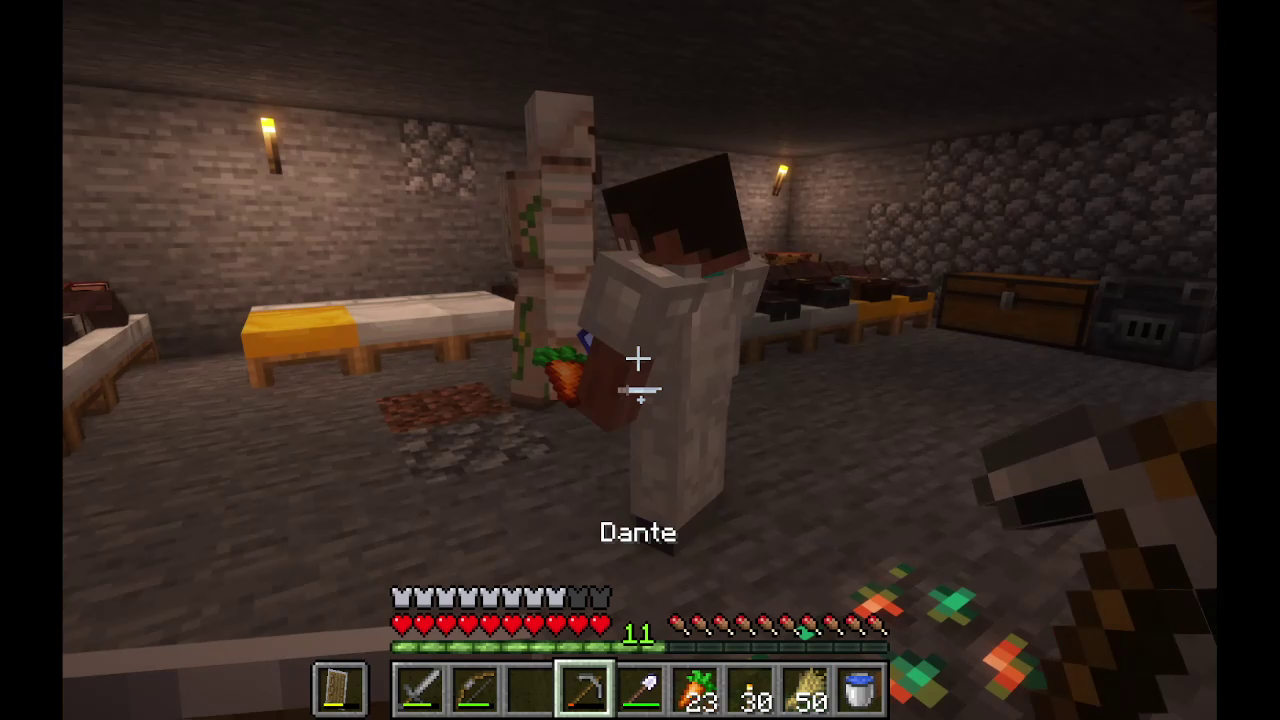

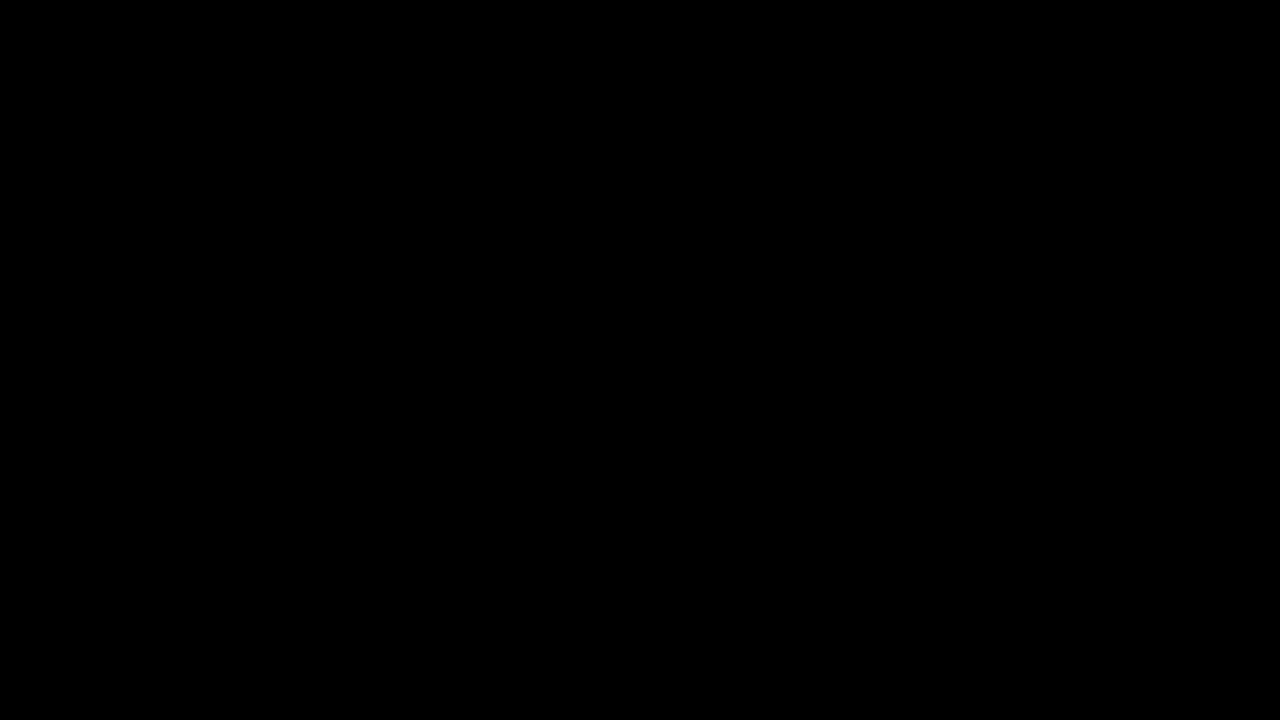

In [79]:
# Create gridspec for better layout control
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import io
import PIL
from matplotlib.lines import Line2D


def create_validation_figure(decoded_outputs):
    """Create matplotlib figures for multi-sample next-step prediction validation
    
    Creates separate visualizations for each sample showing:
    - Top row: Predicted vs Target video frame
    - Middle rows: Audio waveforms (predicted vs target)
    - Bottom rows: Mouse and keyboard action comparisons
    
    Returns:
        List of PIL Images, one for each sample
    """
    figures = []
    for sample_idx in range(decoded_outputs['num_samples']):
        # Create figure with side-by-side layout for single frame comparison
        # 2 columns (pred vs target), 6 rows (video, 2 audio, mouse, keyboard, colorbar)
        fig = plt.figure(figsize=(20, 16))
        # Give more space to video frames (make first row taller)
        gs = gridspec.GridSpec(6, 2, figure=fig, hspace=0.4, wspace=0.3, height_ratios=[3, 1, 1, 1.5, 2, 0.3])
    
        # Plot predicted video frame (left column)
        ax_pred_video = fig.add_subplot(gs[0, 0])
        pred_frame = decoded_outputs['pred_video_frames'][sample_idx].permute(1, 2, 0)
        pred_frame_small = pred_frame[::2, ::2]  # Downsample by 2x (less aggressive)
        ax_pred_video.imshow(pred_frame_small)
        ax_pred_video.set_title('Predicted Next Frame', fontsize=14, fontweight='bold')
        ax_pred_video.axis('off')
        # Plot target video frame (right column)
        ax_target_video = fig.add_subplot(gs[0, 1])
        target_frame = decoded_outputs['target_video_frames'][sample_idx].permute(1, 2, 0)
        target_frame_small = target_frame[::2, ::2]  # Downsample by 2x (less aggressive)
        ax_target_video.imshow(target_frame_small)
        ax_target_video.set_title('Target Next Frame', fontsize=14, fontweight='bold')
        ax_target_video.axis('off')
    
        # Plot audio waveforms - create time axis for AUDIO_FRAMES_PER_VIDEO frames at 24kHz
        pred_transcript_in = decoded_outputs['target_transcript_in']
        target_transcript_in = decoded_outputs['target_transcript_in']
        pred_transcript_out = decoded_outputs['target_transcript_out']
        target_transcript_out = decoded_outputs['target_transcript_out']
        # Audio IN - Predicted (left)
        ax_pred_transcript_in = fig.add_subplot(gs[1, 0])
        ax_pred_transcript_in.text(0.5, 0.5, pred_transcript_in, 
                                   horizontalalignment='center', verticalalignment='center', 
                                   transform=ax_pred_transcript_in.transAxes)
        ax_pred_transcript_in.set_title('Transcript IN', fontsize=10)
        # Audio IN - Target (right)
        ax_target_transcript_in = fig.add_subplot(gs[1, 1])
        ax_target_transcript_in.text(0.5, 0.5, target_transcript_in, 
                                     horizontalalignment='center', verticalalignment='center', 
                                     transform=ax_target_transcript_in.transAxes)
        ax_target_transcript_in.set_title('Transcript IN', fontsize=10)
        # Audio OUT - Predicted (left)
        ax_pred_transcript_out = fig.add_subplot(gs[2, 0])
        ax_pred_transcript_out.text(0.5, 0.5, pred_transcript_out, 
                                    horizontalalignment='center', verticalalignment='center', 
                                    transform=ax_pred_transcript_out.transAxes)
        ax_pred_transcript_out.set_title('Predicted Transcript OUT', fontsize=10)
        # Audio OUT - Target (right)
        ax_target_transcript_out = fig.add_subplot(gs[2, 1])
        ax_target_transcript_out.text(0.5, 0.5, target_transcript_out, 
                                      horizontalalignment='center', verticalalignment='center', 
                                      transform=ax_target_transcript_out.transAxes)
        ax_target_transcript_out.set_title('Target Transcript OUT', fontsize=10)
    
        # Plot action data - mouse trajectory (full width)
        ax_mouse = fig.add_subplot(gs[3, :])
        # # Get mouse data and compute cumulative trajectory
        # pred_mouse_first = decoded_outputs['pred_mouse_movement'][sample_idx].numpy()  # [10, 2]
        # target_mouse_first = decoded_outputs['target_mouse_movement'][sample_idx].numpy()  # [10, 2]
        # # Compute cumulative trajectories (starting from origin)
        # pred_trajectory = np.cumsum(pred_mouse_first, axis=0)  # [10, 2]
        # target_trajectory = np.cumsum(target_mouse_first, axis=0)  # [10, 2]
        # Get mouse data and compute cumulative trajectory
        pred_trajectory = decoded_outputs['pred_mouse_movement'][sample_idx]
        target_trajectory = decoded_outputs['target_mouse_movement'][sample_idx]
        # Plot trajectories
        # ax_mouse.plot(pred_trajectory[:, 0], pred_trajectory[:, 1], 'b-o', label='Predicted', linewidth=2, markersize=4)
        # ax_mouse.plot(target_trajectory[:, 0], target_trajectory[:, 1], 'r-o', label='Target', linewidth=2, markersize=4)
        # Plot predicted arrow (blue)
        ax_mouse.annotate(
            '', xy=pred_trajectory[0], xytext=(0, 0),
            arrowprops=dict(arrowstyle='->', color='blue', linewidth=2),
            label='Predicted'
        )

        # Plot target arrow (red)
        ax_mouse.annotate(
            '', xy=target_trajectory[0], xytext=(0, 0),
            arrowprops=dict(arrowstyle='->', color='red', linewidth=2),
            label='Target'
        )
        ax_mouse.scatter([0], [0], color='green', s=60, marker='s', label='Start', zorder=5)
        ax_mouse.set_title('Mouse Movement Vector (Next Timestep)', fontsize=12)
        ax_mouse.set_xlabel('X Movement (pixels)')
        ax_mouse.set_ylabel('Y Movement (pixels)')
        ax_mouse.set_xlim(-150, 150)
        ax_mouse.set_ylim(-100, 100)
        legend_handles = [
            Line2D([0], [0], color='blue', lw=2, label='Predicted'),
            Line2D([0], [0], color='red', lw=2, label='Target'),
            Line2D([0], [0], marker='s', color='green', linestyle='None', markersize=8, label='Start')
        ]
        ax_mouse.legend(handles=legend_handles)
        ax_mouse.grid(True, alpha=0.3)

        # Keyboard state heatmaps - predicted (left) vs target (right)
        pred_keyboard_first = decoded_outputs['pred_key_press'][sample_idx]
        target_keyboard_first = decoded_outputs['target_key_press'][sample_idx]
        # Predicted keyboard states (left)
        ax_keys_pred = fig.add_subplot(gs[4, 0])
        ax_keys_pred.text(0.5, 0.5, pred_keyboard_first, fontsize=16,
                          horizontalalignment='center', verticalalignment='center', 
                          transform=ax_keys_pred.transAxes)
        ax_keys_pred.set_title('Pressed Keys', fontsize=10)
        ax_keys_pred.set_xticks([])
        ax_keys_pred.set_yticks([])
        # Target keyboard states (right)
        ax_keys_target = fig.add_subplot(gs[4, 1])
        # print(decoded_outputs['target_key_press'][sample_idx].shape)
        # im_target = ax_keys_target.imshow(target_keyboard_first.T, aspect='auto', cmap='YlOrRd', vmin=0, vmax=1)
        ax_keys_target.text(0.5, 0.5, target_keyboard_first, fontsize=16,
                            horizontalalignment='center', verticalalignment='center', 
                            transform=ax_keys_target.transAxes)
        ax_keys_target.set_title('Pressed Keys', fontsize=10)
        ax_keys_target.set_xticks([])
        ax_keys_target.set_yticks([])
        
        # Add shared colorbar (full width at bottom)
        cbar_ax = fig.add_subplot(gs[5, :])
        cbar_ax.axis('off')        
        plt.suptitle(f'Validation Sample {sample_idx + 1}: Next-Step Prediction', fontsize=14)
        plt.tight_layout()
        # Convert to image for WandB
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
        buf.seek(0)
        img = PIL.Image.open(buf)
        plt.close(fig)
        figures.append(img)
    return figures


print(data['video'].shape, data['audio_in'].shape, data['audio_out'].shape, data['action']['key_press'].shape, data['action']['mouse_movement'].shape)
# print(all_key_presses)
# print(all_mouse_movements)
# print(decode_keypress(data['action']['key_press'].flatten(0, 2).transpose(-1, -2)))

out_raw = raw_dataset[0]
key_press_raw = out_raw['action']['key_press'].unsqueeze(0)
print(f"Key Press Raw Shape: {key_press_raw.shape}")
result_raw = decode_keypress(key_press_raw)
print(len(result_raw), result_raw[0].shape)
print(f"Time {0}: {keypress_tensor_to_text(result_raw)}")


target_key_press = data['action']['key_press'].flatten(0, 2).transpose(-1, -2)
print("Target Key Press Shape: ", target_key_press.shape)
target_key_press = decode_keypress(target_key_press)
print("Decoded Target Key Press: ", target_key_press.shape)
target_key_press = keypress_tensor_to_text(decode_keypress(data['action']['key_press'].flatten(0, 2).transpose(-1, -2)))
print("Target Key Press Text: ", target_key_press)


def plot_all(pred, target, max_timesteps=10):
    target_video = target['video'].flatten(0, 2)
    target_transcript_in = target['transcript_in']
    target_transcript_out = target['transcript_out']
    target_key_press = target['action']['key_press'].flatten(0, 2)
    target_mouse_movement = target['action']['mouse_movement'].flatten(0, 2)

    pred_video = torch.zeros_like(target_video)
    pred_key_press = all_key_presses
    pred_mouse_movement = torch.tensor(all_mouse_movements)

    print(len(target_transcript_in))
    print(target_transcript_in)

    figures = []
    num_samples = 1
    for time_index in range(min(max_timesteps, len(target_video))):
        print(f"Time Index: {time_index}")
        decoded_outputs = dict(
            num_samples=1,
            pred_video_frames=pred_video[time_index:time_index+1],
            pred_key_press=pred_key_press,
            pred_mouse_movement=pred_mouse_movement[time_index:time_index+1].transpose(0, 1),  # Shape: [1, 1, 2]
            target_video_frames=target_video[time_index:time_index+1],
            target_transcript_in=' '.join([entry[0] for entry in target_transcript_in[0]]),
            target_transcript_out=' '.join([entry[0] for entry in target_transcript_out[0]]),
            target_key_press=keypress_tensor_to_text(decode_keypress(target_key_press[time_index:time_index+1].transpose(-1, -2))),
            target_mouse_movement=target_mouse_movement[time_index:time_index+1].sum(dim=-2, keepdim=True),  # Shape: [1, 1, 2]
        )
        figures.append(create_validation_figure(decoded_outputs)[num_samples-1])
    return figures



result = data['video'].flatten(0, 2)
print(result[0].shape)
display(Image.fromarray(result[0].permute(1, 2, 0).numpy().astype('uint8')))
display(Image.fromarray(result[1].permute(1, 2, 0).numpy().astype('uint8')))
# figures = plot_all(pred={'key_press': all_key_presses, 'mouse_movement': all_mouse_movements}, target=data)
# for figure in figures:
#     display(figure)